<a href="https://colab.research.google.com/github/ashwani-adu3839/Speech-To-Speech-Generative-Model/blob/main/Conditional_GAN_Speech_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pickle import load
import time
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import IPython.display as ipd
from sklearn.model_selection import train_test_split
import collections
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2})
from sklearn.utils import shuffle
import os

In [ ]:
pickle_path_feature = '/feature_mel_all.pkl'
path='/Speech_to_Speech/'

In [ ]:
FRAME_SIZE = 1024
HOP_LENGTH = 200
DURATION = 0.8  # in seconds
SAMPLE_RATE = 22050
MEL_CHANNELS = 60
win_length  =  1011
max_db = 100
ref_db = 20
power = 0.5

In [ ]:
def load_features(filename):
    # load all features
    data = load(open(filename, 'rb'))

    datax = data["feauture_mfcc"]
    words = data["mapping"]
    labels = []
    for word in words:
      if  word == 'zero':
        label = 0
      if word == 'one':
        label = 1       
      if word == 'two':
        label = 2
      if word == 'three':
        label = 3        
      if word == 'four':
        label = 4
      if word == 'five':
        label = 5        
      if word == 'six':
        label = 6       
      if word == 'seven':
        label = 7  
      if word == 'eight':
        label = 8  
      if word == 'nine':
        label = 9  
      labels.append(label)
    
    x_data = []
    for mel in datax:
        norm_mel = mel
        x_data.append(norm_mel)
        
    length = [x.shape[0] for x in x_data]
    
    pad_len = max([x.shape[0] for x in x_data])
    if pad_len%2 != 0:
       pad_len = pad_len+1
    pad_len = 88   
    pad_mel = 56
    pad_arr = [np.pad(x, ((0, pad_len), (0, 0)), 'constant', constant_values=(0))[:pad_len, :pad_mel] for x in x_data]
    pad_arr = np.array(pad_arr)
    pad_arr = (pad_arr-0.5)/0.5
    
    return pad_arr,labels, length
x_data,y_word, length = load_features(pickle_path_feature)

In [ ]:
x =x_data
xy=np.reshape(x[2], (x[2].shape[0],x[2].shape[1]))
xyt = (xy+1)/2
plt.imshow(xy.T)
plt.colorbar()

In [ ]:
_, T_shape, mel_channels = x.shape
y_train = tf.keras.utils.to_categorical(np.array(y_word), 10)
x_train, y_train = shuffle(x.astype("float32"), y_train, random_state=0)
x_train.shape, y_train.shape

((3000, 88, 56), (3000, 10))

In [ ]:
x_train = np.expand_dims(x_train, -1).astype("float32")

In [ ]:
num_channels = 1
num_classes = 10
image_height = T_shape
image_width = mel_channels
latent_dim = 32

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

In [ ]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(image_height, image_width,discriminator_in_channels)):
    model = tf.keras.Sequential()
    # normal
    model.add(tf.keras.layers.Conv2D(128, (5,5), padding= 'same' , input_shape=in_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # downsample to 40x40
    model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding= 'same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # downsample to 20x30
    model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding= 'same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # downsample to 10x10
    model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding= 'same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # downsample to 5x5
    model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(1,1), padding= 'same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # classifier
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    return model

In [ ]:
discriminator = define_discriminator()

In [ ]:
# define the standalone generator model
def define_generator(generator_in_channels):
    model = tf.keras.Sequential()
    # foundation for 5x5 feature maps
    n_nodes = 128 * 11 * 7
    model.add(tf.keras.layers.Dense(n_nodes, input_dim=generator_in_channels))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((11, 7, 128)))
    # upsample to 10x10
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding= 'same' ))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 20x20
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding= 'same' ))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 40x40
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding= 'same' ))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 80x80
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(1,1), padding= 'same' ))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # output layer 80x80x3
    model.add(tf.keras.layers.Conv2D(1, (5,5), activation=  'tanh' , padding= 'same' ))
    return model

In [ ]:
generator = define_generator(generator_in_channels)
sample = tf.random.normal(shape=(1, generator_in_channels))
generator(sample).shape

TensorShape([1, 88, 56, 1])

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1 =0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1 =0.5)

In [ ]:
checkpoint_path = path+"/Conditional_GAN"

ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss, fake_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
noise_dim = latent_dim

In [ ]:
@tf.function
def train_step(images, label):

    batch_size = tf.shape(images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    noise = tf.concat([random_latent_vectors, label], axis=1)

    # Add dummy dimensions to the labels so that they can be concatenated with
    # This is for the discriminator.
    image_one_hot_labels = label[:, :, None, None]
    image_one_hot_labels = tf.repeat(
        image_one_hot_labels, repeats=[image_height*image_width]
    )
    image_one_hot_labels = tf.reshape(
        image_one_hot_labels, (-1, image_height, image_width, num_classes)
    )

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      generated_images_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
      images_and_labels = tf.concat([images, image_one_hot_labels], -1)

      real_output = discriminator(images_and_labels, training=True)


      fake_output = discriminator(generated_images_and_labels, training=True)

      gen_loss = generator_loss(fake_output)
      real_loss, fake_loss = discriminator_loss(real_output, fake_output)
      disc_loss = real_loss + fake_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return real_loss, fake_loss, gen_loss

In [ ]:
import time
history = {
  "epoch": [],
  "real_loss": [],
  "fake_loss": [],
  "gen_loss" :[],
}

In [ ]:
EPOCHS = 300
for epoch in range(EPOCHS):
    start = time.time()
    real_lossall = 0
    fake_lossall = 0
    gen_lossall = 0
    for batch, (image_batch,label) in enumerate(dataset):
       real_loss, fake_loss, gen_loss = train_step(image_batch, label)
       real_lossall = real_lossall+real_loss
       fake_lossall = fake_lossall+fake_loss
       gen_lossall = gen_lossall+gen_loss
    history['epoch'].append(epoch)
    history['real_loss'].append(real_lossall/(batch+1))
    history['fake_loss'].append(fake_lossall/(batch+1))
    history['gen_loss'].append(gen_lossall/(batch+1))
    if (epoch + 1) % 100 == 0:
       ckpt_save_path = ckpt_manager.save()
    print (f'\nTime for epoch {epoch + 1} is {time.time()-start :.2f} sec')
    print(f'The fake loss is {fake_lossall/(batch+1) :.4f}, real loss is {real_lossall/(batch+1) :.4f} and Gen loss is {gen_lossall/(batch+1) :.4f}')


Time for epoch 1 is 9.73 sec
The fake loss is 0.2039, real loss is 0.1934 and Gen loss is 3.4123

Time for epoch 2 is 9.72 sec
The fake loss is 0.2024, real loss is 0.1924 and Gen loss is 3.3702

Time for epoch 3 is 9.73 sec
The fake loss is 0.2062, real loss is 0.1988 and Gen loss is 3.4405

Time for epoch 4 is 9.73 sec
The fake loss is 0.2239, real loss is 0.2110 and Gen loss is 3.3712

Time for epoch 5 is 9.72 sec
The fake loss is 0.2055, real loss is 0.2100 and Gen loss is 3.4215

Time for epoch 6 is 9.73 sec
The fake loss is 0.2241, real loss is 0.2055 and Gen loss is 3.3581

Time for epoch 7 is 9.72 sec
The fake loss is 0.2216, real loss is 0.2143 and Gen loss is 3.3885

Time for epoch 8 is 9.72 sec
The fake loss is 0.2013, real loss is 0.2027 and Gen loss is 3.4521

Time for epoch 9 is 9.72 sec
The fake loss is 0.2592, real loss is 0.2458 and Gen loss is 3.3983

Time for epoch 10 is 9.72 sec
The fake loss is 0.2005, real loss is 0.1952 and Gen loss is 3.3254

Time for epoch 11 

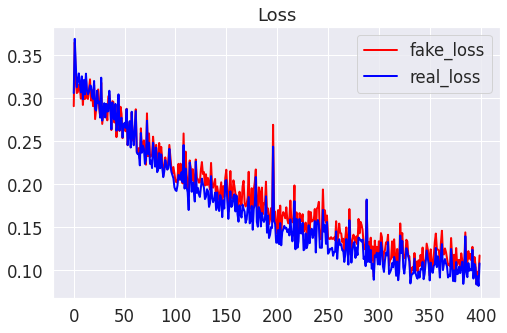

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history["fake_loss"], 'r',label = "fake_loss")
plt.plot(history["real_loss"], 'b', label= "real_loss")
plt.title('Loss')
plt.legend(loc='best')
plt.show()

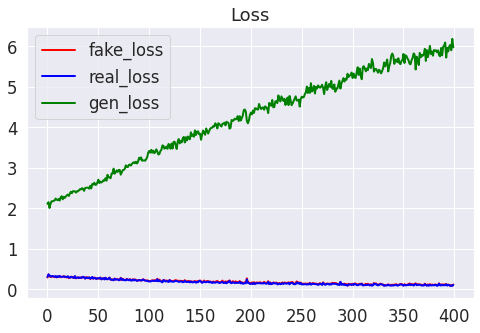

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history["fake_loss"], 'r',label = "fake_loss")
plt.plot(history["real_loss"], 'b', label= "real_loss")
plt.plot(history["gen_loss"], 'g', label= "gen_loss")
plt.title('Loss')
plt.legend(loc='best')
plt.show()

In [ ]:
import copy
import librosa
def griffin_lim(spectrogram, rate=1):
#    spectrogram=spectrogram/10.0
    mel = np.transpose(spectrogram[:-1,:])

        # de-noramlize
    mel = (np.clip(mel, 0, 1) * max_db) - max_db + ref_db

      # to amplitude
    spectrogram = np.power(10.0, mel * 0.05)
    S = librosa.feature.inverse.mel_to_stft(
            spectrogram,
            power=0.5,
            sr=SAMPLE_RATE,
            n_fft=FRAME_SIZE,
            fmin=0,
            fmax=None)
    S_slow = librosa.core.phase_vocoder(S, rate=rate, hop_length=HOP_LENGTH)

    y = librosa.griffinlim(
            S_slow,
            n_iter=32,
            hop_length=HOP_LENGTH,
            win_length=win_length)

    return y

In [ ]:
# Generate sound from latent space
def generate(number):
    label = tf.keras.utils.to_categorical([number], num_classes)
    label = tf.cast(label, tf.float32)
    random_latent_vectors = tf.random.normal(shape=(1, latent_dim))
    noise_and_labels = tf.concat([random_latent_vectors, label], axis=1)

    X = generator(noise_and_labels, training=False).numpy()
    X = (X + 1) / 2.0
    img_inp = X[0,:,:,0]
    y = griffin_lim(img_inp, rate=1)
    print("\n\n\n Digit : ", number)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_inp.T)
    plt.axis('off')
    plt.show()
    ipd.display(ipd.Audio(y, rate=SAMPLE_RATE))




 Digit :  0


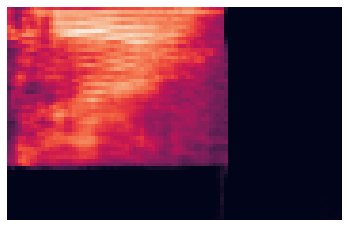




 Digit :  1


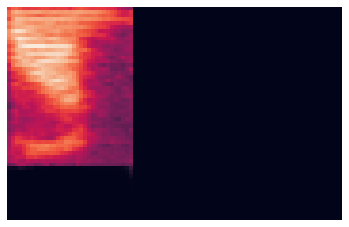




 Digit :  2


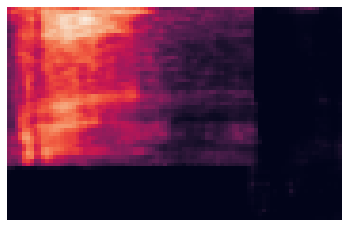




 Digit :  3


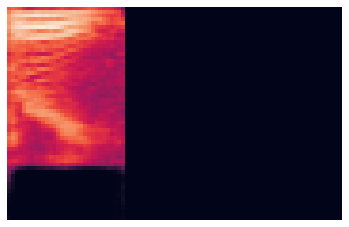




 Digit :  4


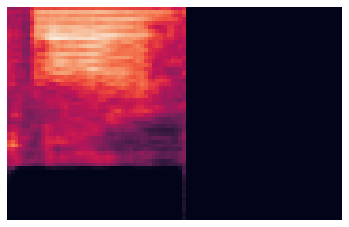




 Digit :  5


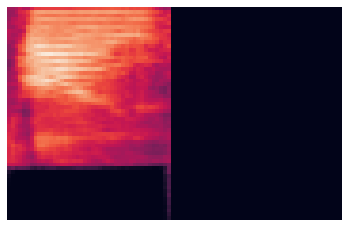




 Digit :  6


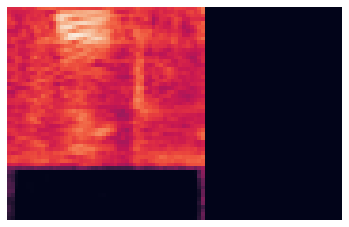




 Digit :  7


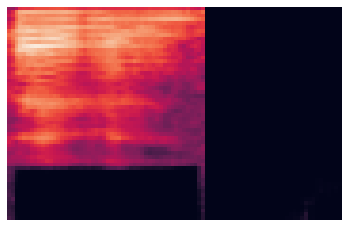




 Digit :  8


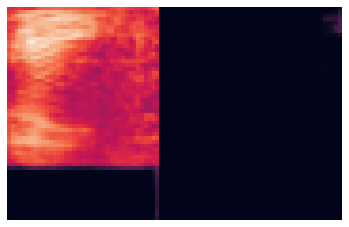




 Digit :  9


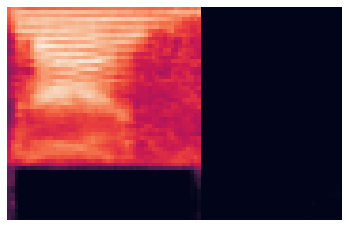

In [ ]:
# Generate digit form 0 to 9
number = np.linspace(0, 9, num=10).astype("int32")
for num in number:
    generate(num)




 Digit :  3


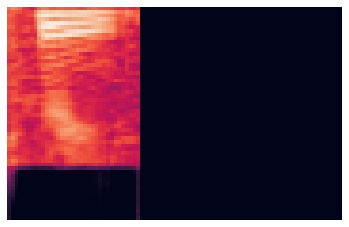




 Digit :  3


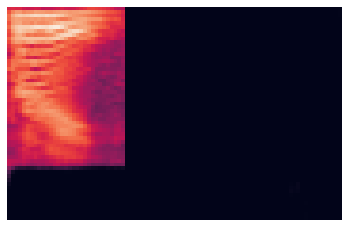




 Digit :  3


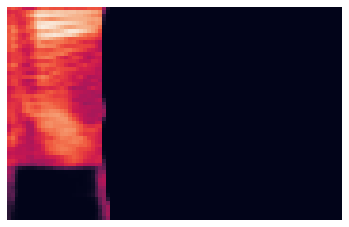




 Digit :  3


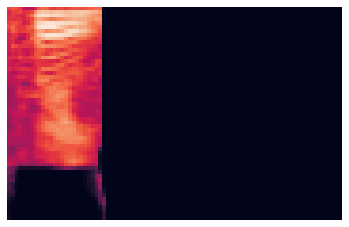




 Digit :  3


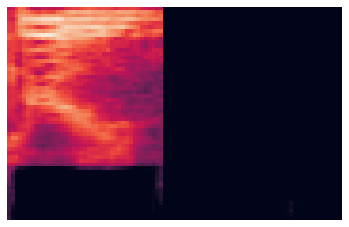

In [ ]:
# Generate same digit with different latent space
num = 3
for i in range(5):
    generate(num)